In [496]:
!pip install catboost --quiet

In [497]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler,OrdinalEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.impute import KNNImputer
from sklearn.ensemble import RandomForestClassifier,AdaBoostClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import ExtraTreeClassifier
from sklearn.metrics import accuracy_score,confusion_matrix,classification_report,f1_score
from scipy.stats import iqr
import requests
from catboost import CatBoostClassifier 

import warnings

warnings.filterwarnings('ignore')
np.set_printoptions(suppress=True)

In [498]:
df = pd.read_csv('./dataset/train1.csv')
test_df = pd.read_csv('./dataset/test1.csv')
df.head()

,Unnamed: 0,customer_id,Name,age,gender,security_no,region_category,membership_category,joining_date,joined_through_referral,referral_id,preferred_offer_types,medium_of_operation,internet_option,last_visit_time,days_since_last_login,avg_time_spent,avg_transaction_value,avg_frequency_login_days,points_in_wallet,used_special_discount,offer_application_preference,past_complaint,complaint_status,feedback,churn_risk_score
0,0,fffe4300490044003600300030003800,Pattie Morrisey,18,F,XW0DQ7H,Village,Platinum Membership,2017-08-17,No,xxxxxxxx,Gift Vouchers/Coupons,?,Wi-Fi,16:08:02,17,300.63,53005.25,17.0,781.75,Yes,Yes,No,Not Applicable,Products always in Stock,2
1,1,fffe43004900440032003100300035003700,Traci Peery,32,F,5K0N3X1,City,Premium Membership,2017-08-28,?,CID21329,Gift Vouchers/Coupons,Desktop,Mobile_Data,12:38:13,16,306.34,12838.38,10.0,NaN,Yes,No,Yes,Solved,Quality Customer Care,1
2,2,fffe4300490044003100390032003600,Merideth Mcmeen,44,F,1F2TCL3,Town,No Membership,2016-11-11,Yes,CID12313,Gift Vouchers/Coupons,Desktop,Wi-Fi,22:53:21,14,516.16,21027.00,22.0,500.69,No,Yes,Yes,Solved in Follow-up,Poor Website,5
3,3,fffe43004900440036003000330031003600,Eufemia Cardwell,37,M,VJGJ33N,City,No Membership,2016-10-29,Yes,CID3793,Gift Vouchers/Coupons,Desktop,Mobile_Data,15:57:50,11,53.27,25239.56,6.0,567.66,No,Yes,Yes,Unsolved,Poor Website,5
4,4,fffe43004900440031003900350030003600,Meghan Kosak,31,F,SVZXCWB,City,No Membership,2017-09-12,No,xxxxxxxx,Credit/Debit Card Offers,Smartphone,Mobile_Data,15:46:44,20,113.13,24483.66,16.0,663.06,No,Yes,Yes,Solved,Poor Website,5


In [499]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36992 entries, 0 to 36991
Data columns (total 26 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Unnamed: 0                    36992 non-null  int64  
 1   customer_id                   36992 non-null  object 
 2   Name                          36992 non-null  object 
 3   age                           36992 non-null  int64  
 4   gender                        36992 non-null  object 
 5   security_no                   36992 non-null  object 
 6   region_category               31564 non-null  object 
 7   membership_category           36992 non-null  object 
 8   joining_date                  36992 non-null  object 
 9   joined_through_referral       36992 non-null  object 
 10  referral_id                   36992 non-null  object 
 11  preferred_offer_types         36704 non-null  object 
 12  medium_of_operation           36992 non-null  object 
 13  i

In [500]:
df.describe()

,Unnamed: 0,age,days_since_last_login,avg_time_spent,avg_transaction_value,points_in_wallet,churn_risk_score
count,36992.000000,36992.000000,36992.000000,36992.000000,36992.000000,33549.000000,36992.000000
mean,18495.500000,37.118161,-41.915576,243.472334,29271.194003,686.882199,3.463397
std,10678.814916,15.867412,228.819900,398.289149,19444.806226,194.063624,1.409661
min,0.000000,10.000000,-999.000000,-2814.109110,800.460000,-760.661236,-1.000000
25%,9247.750000,23.000000,8.000000,60.102500,14177.540000,616.150000,3.000000
50%,18495.500000,37.000000,12.000000,161.765000,27554.485000,697.620000,4.000000
75%,27743.250000,51.000000,16.000000,356.515000,40855.110000,763.950000,5.000000
max,36991.000000,64.000000,26.000000,3235.578521,99914.050000,2069.069761,5.000000


#### Conclusion from the above table:
1. *age* field looks good and don't have any outliers. But the minimum age is 10 so it can be analysed further if required.
2. *days_since_last_login* field has many missing values (-999) and also have negative values  which needs to be handled further.
3. *avg_time_spent* field also have negative values which also needs to be handled properly.
4. *avg_transaction_value* field looks good too.
5. *points_in_wallet* have negative values which needs to be handled appropriately.
6. *churn_risk_score* has also value as -1 which needs to be handled further.

In [501]:
#Check for null values
na_dict = dict(df.isna().sum())
dct_new = {}
for i in na_dict.items():
  if i[1]!=0:
    dct_new[i[0]] = i[1]
print(dct_new)

{'region_category': 5428, 'preferred_offer_types': 288, 'points_in_wallet': 3443}


## Exploratory Data Analysis

In [502]:
min_age = df['age'].min()
max_age = df['age'].max()
print('Min age of customer is {} and max age is {}'.format(min_age,max_age))

Min age of customer is 10 and max age is 64


In [503]:
age_groups = pd.cut(df['age'],bins=[10,25,64])
pd.crosstab(age_groups,df['churn_risk_score'])

churn_risk_score,-1,1,2,3,4,5
age,,,,,,
"(10, 25]",322,688,756,2850,2752,2564
"(25, 64]",820,1933,1923,7368,7270,7076


#### Age grouping is done based on the employement

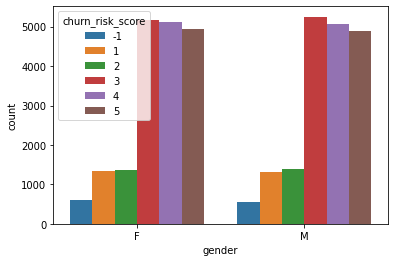

In [504]:
sns.countplot(df['gender'],hue=df['churn_risk_score'])

#### Gender also has some missing values as here we can see the unknown values

In [505]:
print('Total Unknown values in gender {}'.format(df[df['gender'].isin(['Unknown'])]['gender'].count()))

Total Unknown values in gender 0


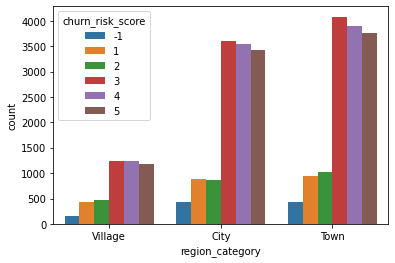

In [506]:
sns.countplot(df['region_category'],hue=df['churn_risk_score'])

#### We can see that city and town has high risk
#### This also has missing values which needs to be imputed further

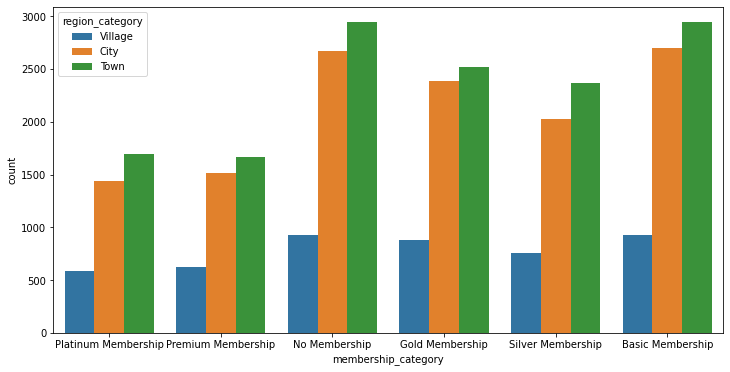

In [507]:
fig,ax = plt.subplots(figsize=(12,6))
sns.countplot(df['membership_category'],hue=df['region_category'],ax=ax)

#### Type of memberships based on the locations/regions

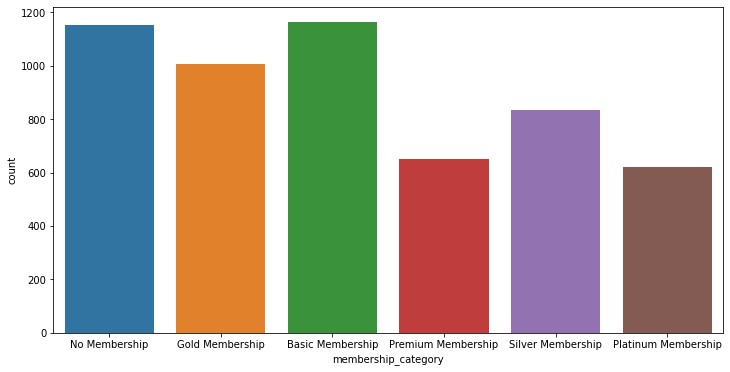

In [508]:
fig,ax = plt.subplots(figsize=(12,6))
sns.countplot(df[df['region_category'].isna()]['membership_category'],ax=ax)

#### Checking membership types where region_category is null values

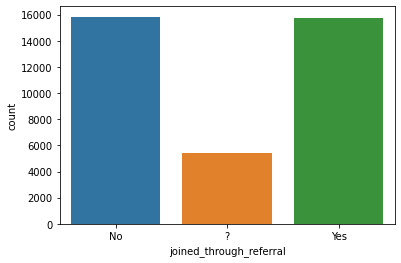

In [509]:
sns.countplot(df['joined_through_referral'])

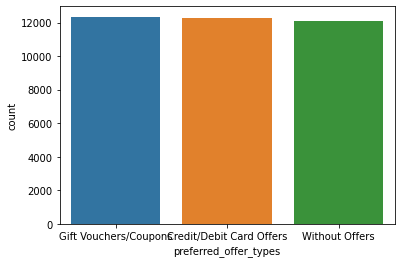

In [510]:
sns.countplot(df['preferred_offer_types'])

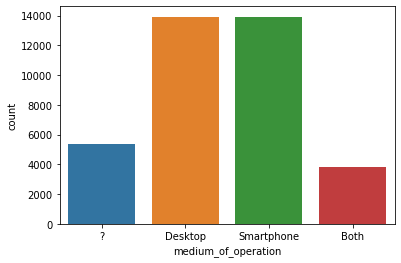

In [511]:
sns.countplot(df['medium_of_operation'])

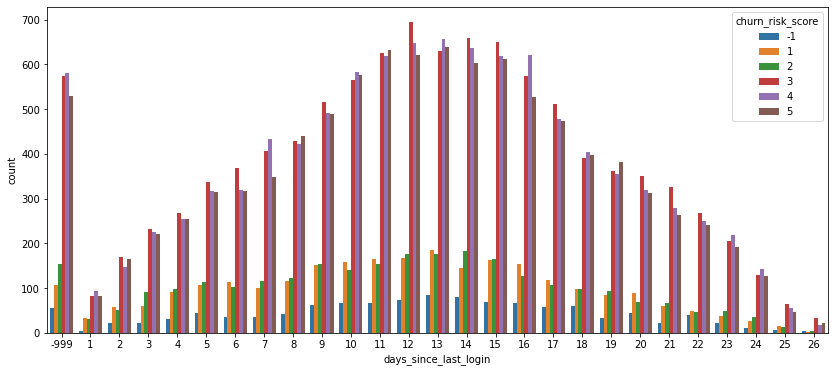

In [512]:
fig,ax = plt.subplots(figsize=(14,6))
sns.countplot(df['days_since_last_login'],hue=df['churn_risk_score'],ax=ax)

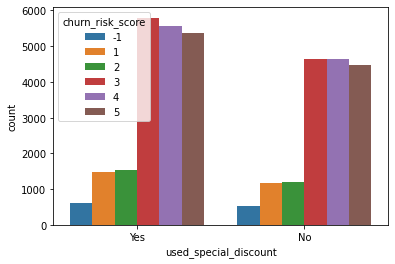

In [513]:
sns.countplot(df['used_special_discount'],hue=df['churn_risk_score'])

#### From the above graph it can be inferred that those who has used the discount has a little high churn risk. 

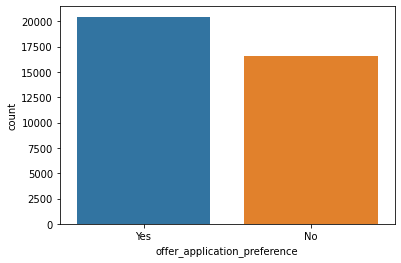

In [514]:
#Represents whether customer prefer offers
sns.countplot(df['offer_application_preference'])

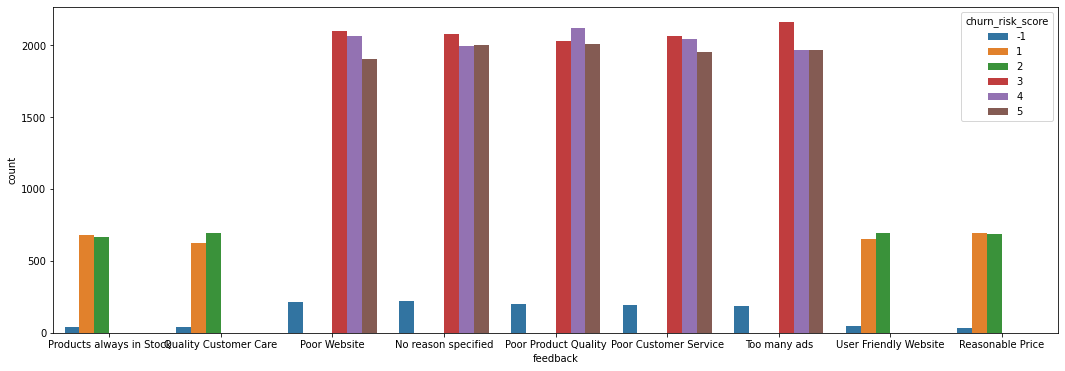

In [515]:
fig,ax = plt.subplots(figsize=(18,6))
sns.countplot(df['feedback'],hue=df['churn_risk_score'],ax=ax)

#### This graph will help in encoding the categories based on the feedback so, it's an important feature.
#### We can group the positive and negative feedback

In [516]:
df['churn_risk_score'].value_counts().reset_index().rename({'index':'score','churn_risk_score':'count'},axis=1)

,score,count
0,3,10424
1,4,10185
2,5,9827
3,2,2741
4,1,2652
5,-1,1163


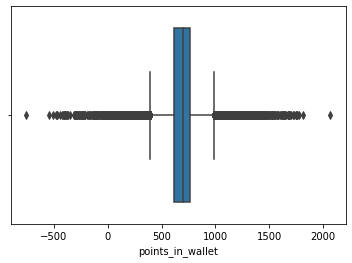

In [517]:
sns.boxplot(df['points_in_wallet'])

#### Here we may see there's lots of outlier but since it's as wallet points which can really vary between different ranges. We can also see the negative values which can be treated as outlier iff we don't have the credit system in place 

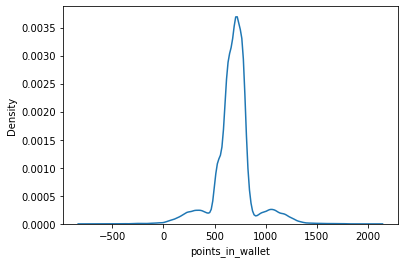

In [518]:
sns.kdeplot(df['points_in_wallet'])

In [519]:
df[df['points_in_wallet']<-50][df['avg_transaction_value']>50000][['points_in_wallet','churn_risk_score','avg_transaction_value']]

,points_in_wallet,churn_risk_score,avg_transaction_value
625,-301.998780,1,87823.92
4214,-96.613259,1,52180.83
7593,-77.782543,2,93902.80
9639,-132.429825,1,51213.42
10375,-293.570269,2,50451.67
15743,-298.736774,2,63399.63
23278,-102.695584,2,56349.20
24870,-110.205647,1,81628.48
26953,-129.172271,2,73125.88


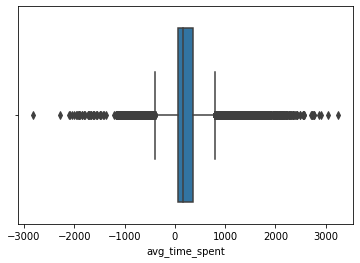

In [520]:
sns.boxplot(df['avg_time_spent'])

#### we can see that there is lot's of outliers in this avg_time_spent_attribute. Most of the values are also negative as can be seen

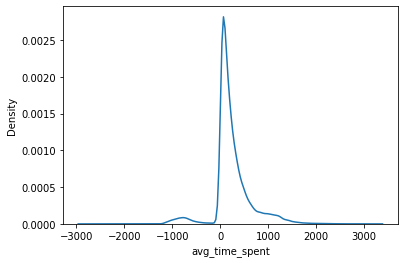

In [521]:
sns.kdeplot(df['avg_time_spent'])

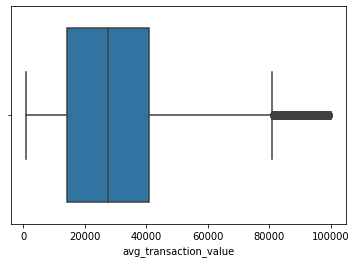

In [522]:
sns.boxplot(df['avg_transaction_value'])

#### This may not  be treated as outliers since the txn amounts can vary

In [523]:
df[df['avg_transaction_value']>50000][['churn_risk_score','feedback']].tail(35)

,churn_risk_score,feedback
36576,1,Products always in Stock
36605,1,User Friendly Website
36609,2,User Friendly Website
36616,2,User Friendly Website
36618,2,User Friendly Website
36621,1,Reasonable Price
36635,2,Quality Customer Care
36644,1,Quality Customer Care
36649,1,User Friendly Website
36662,1,Quality Customer Care


#### After checking this table we can say that those who has have average transaction value of more then 50000 have less churn risk score(1 or 2) so, from this inference we can create new feature based on the avg_transaction_value for 50000 and more.

In [524]:
df.select_dtypes('object').columns

Index(['customer_id', 'Name', 'gender', 'security_no', 'region_category',
       'membership_category', 'joining_date', 'joined_through_referral',
       'referral_id', 'preferred_offer_types', 'medium_of_operation',
       'internet_option', 'last_visit_time', 'avg_frequency_login_days',
       'used_special_discount', 'offer_application_preference',
       'past_complaint', 'complaint_status', 'feedback'],
      dtype='object')

In [525]:
#Checking for duplicate rows
df_dups = len(df[df.duplicated()])
testdf_dups = len(test_df[test_df.duplicated()])
print('Duplicates in train file  is: {} and in test file is: {}'.format(df_dups,testdf_dups))

Duplicates in train file  is: 0 and in test file is: 0


In [526]:
df['security_no'].value_counts().sum()

36992

#### This also confirms that their is no duplicate values in the dataset as each person has unique security no. assigned.


## Data Cleaning & Feature Engineering

### Handling Missing attributes
#### Missing attributes are:
1. gender (Unknown) --already solved using genderize API 
2. region_category (NaN)
3. joined_through_referral (?)
4. medium_of_operation (?)
5. preferred_offer_types (NaN)
6. points_in_wallet (NaN)
7. days_since_last_login (-999)

In [527]:
#Replacing hidden Missing values with NaN
df['gender'].replace({'Unknown':np.nan},inplace=True)
test_df['gender'].replace({'Unknown':np.nan},inplace=True)
df['joined_through_referral'].replace({'?':np.nan},inplace=True)
test_df['joined_through_referral'].replace({'?':np.nan},inplace=True)
df['days_since_last_login'].replace({-999:np.nan},inplace=True)
test_df['days_since_last_login'].replace({-999:np.nan},inplace=True)
df['medium_of_operation'].replace({'?':np.nan},inplace=True)
test_df['medium_of_operation'].replace({'?':np.nan},inplace=True)
df['churn_risk_score'].replace({-1:np.nan},inplace=True)

In [528]:
#Binary Encoding
df['gender'].replace({'M':1,'F':0},inplace=True)
df['joined_through_referral'].replace({'Yes':1,'No':0,},inplace=True)
df['used_special_discount'].replace({'Yes':1,'No':0},inplace=True)
df['offer_application_preference'].replace({'Yes':1,'No':0},inplace=True)
df['past_complaint'].replace({'Yes':1,'No':0},inplace=True)
df['feedback'] = np.where(df['feedback'].isin(['Reasonable Price','User Friendly Website','Products always in Stock','Quality Customer Care']),1,0)
df['days_since_last_login'].replace({-999:np.nan},inplace=True)
test_df['gender'].replace({'M':1,'F':0,'Unknown':np.nan},inplace=True)
test_df['joined_through_referral'].replace({'Yes':1,'No':0,'?':np.nan},inplace=True)
test_df['used_special_discount'].replace({'Yes':1,'No':0},inplace=True)
test_df['offer_application_preference'].replace({'Yes':1,'No':0},inplace=True)
test_df['past_complaint'].replace({'Yes':1,'No':0},inplace=True)
test_df['days_since_last_login'].replace({-999:np.nan},inplace=True)
test_df['feedback'] = np.where(test_df['feedback'].isin(['Reasonable Price','User Friendly Website','Products always in Stock','Quality Customer Care']),1,0)

# #labelEncoding Feedback
# df['feedback'] = df['feedback'].replace({'User Friendly Website':0,'Reasonable Price':0,
#                                          'Quality Customer Care':0,'Products always in Stock':0,
#                                         'No reason specified':1,'Poor Customer Service':2,
#                                         'Poor Product Quality':2,'Poor Website':2,'Too many ads':2})
# #labelEncoding Feedback
# test_df['feedback'] = test_df['feedback'].replace({'User Friendly Website':0,'Reasonable Price':0,
#                                          'Quality Customer Care':0,'Products always in Stock':0,
#                                         'No reason specified':1,'Poor Customer Service':2,
#                                         'Poor Product Quality':2,'Poor Website':2,'Too many ads':2})

In [529]:
df['avg_frequency_login_days'].replace({'Error':np.nan},inplace=True)
df['avg_frequency_login_days'] = df['avg_frequency_login_days'].astype('float')
test_df['avg_frequency_login_days'].replace({'Error':np.nan},inplace=True)
test_df['avg_frequency_login_days'] = test_df['avg_frequency_login_days'].astype('float')

In [530]:
#Check missing values after converting all missings to NaN
df.isna().sum()

Unnamed: 0                         0
customer_id                        0
Name                               0
age                                0
gender                             0
security_no                        0
region_category                 5428
membership_category                0
joining_date                       0
joined_through_referral         5438
referral_id                        0
preferred_offer_types            288
medium_of_operation             5393
internet_option                    0
last_visit_time                    0
days_since_last_login           1999
avg_time_spent                     0
avg_transaction_value              0
avg_frequency_login_days        3522
points_in_wallet                3443
used_special_discount              0
offer_application_preference       0
past_complaint                     0
complaint_status                   0
feedback                           0
churn_risk_score                1163
dtype: int64

#### For imputing gender i will use name to gender mapping API's. This method will provide more accurate imputation then other methods. We will use the first name to find the gender of particular person.
#### For this purpose am going to use <i>genderize<i> api.

In [531]:
url = 'https://api.genderize.io/?'
# Preparing data for the API request
first_names_data = ['name='+x.split(" ")[0]+'&' for x in df['Name']]

#Sending API request and fetching & processing the data recieved
#     req_string = ''.join(first_names_data[i:i+10])
def fill_gender(df):
    df = df.copy()
    for i in range(len(df)):
        if pd.isna(df.iloc[i]['gender']):
            res = requests.get(url+'name='+df['Name'][i].split(" ")[0])
            json_res = res.json()
            print(json_res)
            if json_res['gender']=='female':
                df['gender'][i] = 0
            else:
                df['gender'][i] = 1
    return df
        

In [532]:
# df = fill_gender(df)
# test_df = fill_gender(testt_df)

In [533]:
df['region_category'].fillna('Village',inplace=True)
test_df['region_category'].fillna('Village',inplace=True)

#### We can impute joined_through_referral missing values using that refferal_id column as it may be most possible that if a user has joined through any referral than he/she must have applied some referral ID.

In [534]:
def fill_joined_through_referral(df):
    df = df.copy()
#     df['joined_through_referral'] = df['joined_through_referral'].astype('int')
    for i in range(len(df)):
        if pd.isna(df.iloc[i]['joined_through_referral']):
            if df.iloc[i]['referral_id']=='xxxxxxxx':
                df['joined_through_referral'][i] = 0
            else:
                df['joined_through_referral'][i] = 1
    return df

In [535]:
df = fill_joined_through_referral(df)
test_df = fill_joined_through_referral(test_df)
df.joined_through_referral.isna().sum()

0

In [536]:
# Replacing with most occuring value
df['preferred_offer_types'].fillna('Gift Vouchers/Coupons',inplace=True)
test_df['preferred_offer_types'].fillna('Without Offers',inplace=True)

In [537]:
# Replacing with most occuring value
df['medium_of_operation'].fillna('Desktop',inplace=True)
test_df['medium_of_operation'].fillna('Desktop',inplace=True)

In [538]:
#Replacing with most occuring value
df['avg_frequency_login_days'].fillna(13,inplace=True)
test_df['avg_frequency_login_days'].fillna(15,inplace=True)

In [539]:
#Replacing with Mean value
df['points_in_wallet'].fillna(686,inplace=True)
test_df['points_in_wallet'].fillna(686,inplace=True)

In [540]:
# Replacing with most occuring value
df['days_since_last_login'].fillna(df['days_since_last_login'].median(),inplace=True)
test_df['days_since_last_login'].fillna(df['days_since_last_login'].median(),inplace=True)

In [541]:
# Handling -1(NaN) in churn_risk_score (target variable)
# for i in range(len(df)):
#     if pd.isna(df.iloc[i]['churn_risk_score']):
#         if df.iloc[i]['feedback']==1:
#             df['churn_risk_score'][i] = 1
#         else:
#             df['churn_risk_score'][i] = 3

#Replacing NaN in churn_risk_score with 1 (Assuming it was mislabeled as -1 earlier)
df['churn_risk_score'].fillna(1,inplace=True)

# Converting values from float to int
df['churn_risk_score'] = df['churn_risk_score'].astype('int')


In [542]:
tot_null_train = df.isna().sum().sum()
tot_null_test = test_df.isna().sum().sum()
print('Total null values present in train are: {}'.format(tot_null_train))
print('Total null values present in test are: {}'.format(tot_null_test))

Total null values present in train are: 0
Total null values present in test are: 0




### Feature Encoding

In [543]:
#One_hot encoding nominal variables
def one_hot(df,columns,prefixes):
    df = df.copy()
    for column,prefix in zip(columns,prefixes):
        dummies = pd.get_dummies(df[column],prefix=prefix,drop_first=True)
        df = pd.concat([df,dummies],axis=1)
        df = df.drop(column,axis=1)
    return df

In [544]:
nominal_features = ['preferred_offer_types',
                    'medium_of_operation', 'internet_option', 'complaint_status','region_category','membership_category']
prefixes = ['pref','med','int','comp','reg','mem']

df = one_hot(df,nominal_features,prefixes)
test_df = one_hot(test_df,nominal_features,prefixes)

In [545]:
#Ordinal Encoding
def ord_enc(df,col,ord_var):
    df = df.copy()
    df[col].replace(ord_var,inplace=True)
    return df

In [546]:
#Encoding Ordinal columns
# df['membership_category'].value_counts()
mem_ord = {'No Membership':5,'Basic Membership':4,'Silver Membership':3,
          'Gold Membership':2,'Premium Membership':1,'Platinum Membership':0}
reg_ord = {'Village':2,'Town':1,'City':0}
feedback_ord = {'User Friendly Website':0,'Reasonable Price':1,'Products always in Stock':2,'Quality Customer Care':3,
               'No reason specified':4,'Poor Customer Service':5,'Poor Product Quality':6,'Poor Website':7,'Too many ads':8}
comp_ord = {'Solved':1,'Solved in Follow-up':2,'Not Applicable':3,'No Information Available':4,'Unsolved':5}


# df = ord_enc(df,'membership_category',mem_ord)
# test_df = ord_enc(test_df,'membership_category',mem_ord)

# df = ord_enc(df,'region_category',reg_ord)
# test_df = ord_enc(test_df,'region_category',reg_ord)

# df = ord_enc(df,'complaint_status',comp_ord)
# test_df = ord_enc(test_df,'complaint_status',comp_ord)

# df = ord_enc(df,'feedback',feedback_ord)
# test_df = ord_enc(test_df,'feedback',feedback_ord)

In [547]:
#Encoding other categorical columns (Labeling)
med_lbl = {'Desktop':1,'Smartphone':2,'Both':3}
int_lbl = {'Wi-Fi':1,'Mobile_Data':2,'Fiber_Optic':3}
offer_lbl = {'Gift Vouchers/Coupons':1,'Credit/Debit Card Offers':2,'Without Offers':3}

# df['medium_of_operation'].replace(med_lbl,inplace=True)
# test_df['medium_of_operation'].replace(med_lbl,inplace=True)

# df['internet_option'].replace(int_lbl,inplace=True)
# test_df['internet_option'].replace(int_lbl,inplace=True)

# df['preferred_offer_types'].replace(offer_lbl,inplace=True)
# test_df['preferred_offer_types'].replace(offer_lbl,inplace=True)

In [548]:
df.select_dtypes('object').columns

Index(['customer_id', 'Name', 'security_no', 'joining_date', 'referral_id',
       'last_visit_time'],
      dtype='object')

### Feature Generation

In [549]:
# Deriving new feature from the column joining_date
df['days_since_joined'] = df['joining_date'].apply(lambda x:(pd.Timestamp('today') - pd.to_datetime(x)).days)
test_df['days_since_joined'] = test_df['joining_date'].apply(lambda x:(pd.Timestamp('today') - pd.to_datetime(x)).days)

In [550]:
df['avg_transaction_50000'] = np.where(df['avg_transaction_value']>50000,1,0)
test_df['avg_transaction_50000'] = np.where(test_df['avg_transaction_value']>50000,1,0)

#### Removing unwanted features from the dataframe
1. customer_id
2. Name
3. security_no
4. joining_date
5. referral_id
6. last_visit_time
7. Unnamed: 0

In [551]:
df.drop(columns=['customer_id','Name','security_no','joining_date','referral_id','last_visit_time','Unnamed: 0'],inplace=True)
test_df.drop(columns=['customer_id','Name','security_no','joining_date','referral_id','last_visit_time','Unnamed: 0'],inplace=True)

### Other method (Using KNN) to fill the churn_risk_score missing class indicated by -1 (NaN)

In [552]:
# X_churn = df[~df['churn_risk_score'].isna()].drop('churn_risk_score',axis=1)
# Y_churn = df[~df['churn_risk_score'].isna()][['churn_risk_score']].astype('int')
# testX_churn = df[df['churn_risk_score'].isna()].drop('churn_risk_score',axis=1)
# scaler = StandardScaler()

# Y_churn.replace({5:0},inplace=True)

# # Selecting continous features that needs to be scaled
# scale_feat = ['points_in_wallet','avg_transaction_value']
# X_churn[scale_feat] = scaler.fit_transform(X_churn[scale_feat])
# testX_churn[scale_feat] = scaler.fit_transform(testX_churn[scale_feat])

In [553]:
# knn = KNeighborsClassifier(n_neighbors=5)
# knn.fit(X_churn,Y_churn)

In [554]:
# pred = knn.predict(testX_churn)

In [555]:
# from collections import Counter
# Counter(pred)

## Data splitting/training

### Splitting

In [556]:
X = df.drop(columns=['churn_risk_score'])
y = df['churn_risk_score']

In [557]:
trainX,testX,trainY,testY = train_test_split(X,y,random_state=42,test_size=0.2)

### Training

In [558]:
model_acc_scores = {}
def predictionResult(testY,pred,model):
    conf_mat = confusion_matrix(testY,pred)
    correct = conf_mat[0,0]+conf_mat[1,1]+conf_mat[2,2]+conf_mat[3,3]+conf_mat[4,4]
    wrong = conf_mat.sum() - correct
    acc_score = accuracy_score(testY,pred)
    model_acc_scores[model] = {'correct':correct,'wrong':wrong,
                               'accuracy_score':acc_score}
    print("{} {} {}".format("-"*20,model,"-"*20))
    print('Score is: {}'.format(round(f1_score(testY,pred,average='macro')*100,2)))
    print("Model predicted {} correct and {} wrong".format(correct,wrong))
    print("Accuracy Score is: {}%".format(round(acc_score*100,2)))
    print(classification_report(testY,pred))
    sns.heatmap(confusion_matrix(testY,pred),annot=True,fmt='d')

0:	learn: 0.7546248	test: 0.7522544	best: 0.7522544 (0)	total: 268ms	remaining: 6m 42s
50:	learn: 0.7559810	test: 0.7546333	best: 0.7552005 (4)	total: 7.89s	remaining: 3m 44s
100:	learn: 0.7564317	test: 0.7543981	best: 0.7552005 (4)	total: 15.5s	remaining: 3m 34s
150:	learn: 0.7562229	test: 0.7543295	best: 0.7552005 (4)	total: 23.1s	remaining: 3m 25s
200:	learn: 0.7562541	test: 0.7545091	best: 0.7552005 (4)	total: 30.6s	remaining: 3m 17s
250:	learn: 0.7563854	test: 0.7544537	best: 0.7552005 (4)	total: 38.2s	remaining: 3m 10s
300:	learn: 0.7563042	test: 0.7544537	best: 0.7552005 (4)	total: 45.8s	remaining: 3m 2s
400:	learn: 0.7564105	test: 0.7547575	best: 0.7552005 (4)	total: 1m	remaining: 2m 47s
450:	learn: 0.7565108	test: 0.7549503	best: 0.7552005 (4)	total: 1m 8s	remaining: 2m 39s
500:	learn: 0.7564253	test: 0.7549503	best: 0.7552005 (4)	total: 1m 16s	remaining: 2m 31s
550:	learn: 0.7563856	test: 0.7552541	best: 0.7553783 (525)	total: 1m 23s	remaining: 2m 24s
600:	learn: 0.7563189	te

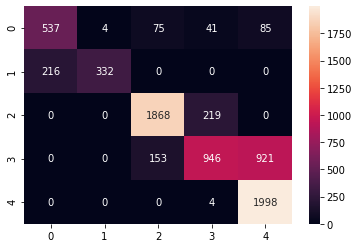

In [559]:
model_cat = CatBoostClassifier(learning_rate=0.0001,
                               depth=13,
                               use_best_model=True,
                               iterations=1500,
                               verbose=50,
                               eval_metric='TotalF1',
                               task_type='GPU')
model_cat.fit(X,y,eval_set=(testX,testY))

pred = model_cat.predict(testX)

predictionResult(testY,pred,'CatBoostClassifier')

In [560]:
#For copying customer ID to final output
df_test_new = pd.read_csv('./dataset/test1.csv')

In [561]:
X_submission = test_df
final_pred = model_cat.predict(X_submission)
final_pred = final_pred.astype('int')

In [562]:
pred_df = pd.DataFrame(final_pred)
final_df = pd.concat([df_test_new['customer_id'],pred_df],axis=1)
final_df.columns = ['customer_id','churn_risk_score']
final_df.head()

,customer_id,churn_risk_score
0,fffe43004900440031003700300030003400,3
1,fffe43004900440031003900370037003300,3
2,fffe43004900440034003800360037003000,3
3,fffe43004900440036003200370033003400,3
4,fffe43004900440035003000370031003900,5


In [563]:
# Write to csv file
final_df.to_csv('final_prediction.csv',index=False)

In [564]:
final_df['churn_risk_score'].value_counts()

5    7864
3    5617
4    3428
1    2239
2     771
Name: churn_risk_score, dtype: int64